# setup


In [1]:
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from ase import io

from sklearn.metrics import mean_squared_error
from scipy import stats, optimize

In [2]:
from toolbox.utils.utils import load_dict
from toolbox.utils.math import cumave, handle_zero_division
from toolbox.io.cp2k import Cp2kPdos
from toolbox import plot

In [3]:
plot.use_style("pub")

In [4]:
data_dir = "../large_files/"

# main text


In [5]:
out_data = {}

In [6]:
fnames = glob.glob("../05.elec_eps/02.pure_slab/data/eps_data.*.pkl")
fnames.sort()
dnames = glob.glob("../05.elec_eps/02.pure_slab/calc/task.000.*/")
dnames.sort()

x_out = []
inveps_out = []
for fname, dname in zip(fnames, dnames):
    atoms = io.read(os.path.join(dname, "coord.xyz"))
    z = atoms.get_positions()[:, 2]
    z_ave = np.sort(z)[-36:].mean()

    data = load_dict(fname)[0.0]
    x_out.append(data["v_prime_grid"] - z_ave)
    inveps_out.append(data["inveps"][-1])
x_out = np.mean(x_out, axis=0)
inveps_out = np.mean(inveps_out, axis=0)

out_data["elec_inveps_metal"] = np.array([x_out, inveps_out])

In [7]:
dnames = glob.glob("../05.elec_eps/01.eps_calc/calc/*/")
dnames.sort()

x_out = []
inveps_out = []
for dname in dnames:
    task_info = load_dict(os.path.join(dname, "task_info.json"))
    # print(task_info["lo"]["z_ave"])
    for prefix in ["lo", "hi"]:
        z_ave = task_info[prefix]["z_ave"]
        data = load_dict(os.path.join(dname, "eps_data_%s.pkl" % prefix))[0.0]
        x_out.append(data["v_prime_grid"] - z_ave)
        inveps_out.append(data["inveps"][-1])
x_out = np.mean(x_out, axis=0)
inveps_out = np.mean(inveps_out, axis=0)

out_data["elec_inveps"] = np.array([x_out, inveps_out])

In [8]:
dnames = glob.glob("../05.elec_eps/03.water_polarizability/00*.000/")
dnames.sort()

norm_chi = []
wat_eden = []
for dname in dnames:
    for prefix in ["lo", "hi"]:
        data = np.load(os.path.join(dname, "%s_wat_norm_chi.npy" % prefix))
        norm_chi.append(data[:530])
        data = np.load(os.path.join(dname, "%s_wat_eden.npy" % prefix))
        wat_eden.append(data[:530])
grid = np.load(os.path.join(dname, "%s_grid.npy" % prefix))[:530]

norm_chi_std = np.std(norm_chi, axis=0)
norm_chi = np.mean(norm_chi, axis=0)
wat_eden_std = np.std(wat_eden, axis=0)
wat_eden = np.mean(wat_eden, axis=0)

mask = (grid >= 0.0) & (grid <= 20.0)
out_data["water_polarizability"] = np.array(
    [grid[mask], norm_chi[mask], norm_chi_std[mask], wat_eden[mask], wat_eden_std[mask]]
)

In [9]:
def fold_data(x, y):
    z1 = 5.837249160546613
    z2 = 35.670679675482106
    d_bins = 0.1

    bins = np.arange(0.0, (z2 - z1) / 2, d_bins)

    xp = x - z1
    fp = y
    y1 = np.interp(bins, xp, fp)
    xp = np.flip(z2 - x)
    fp = np.flip(y)
    y2 = np.interp(bins, xp, fp)
    return bins, (y1 + y2) / 2

In [13]:
out_data["orient_inveps"] = {}

fname = "../06.orient_eps/00.spce_pc/inveps.pkl"
data = load_dict(fname)
x, y = fold_data(data["bins"], data["inveps"])
out_data["orient_inveps"]["spce_pc"] = [x, y]

# plt.plot(data["bins"], data["inveps"])
# plt.plot(x, y)

fname = "../06.orient_eps/01.dw_gaussian/inveps.pkl"
data = load_dict(fname)
x, y = fold_data(data["bins"], data["inveps"])
out_data["orient_inveps"]["dw_gaussian"] = [x, y]

# plt.plot(data["bins"], data["inveps"])
# plt.plot(x, y)

# plt.show()

## $\Delta\rho$ and $\varepsilon^{-1}_{elec}$


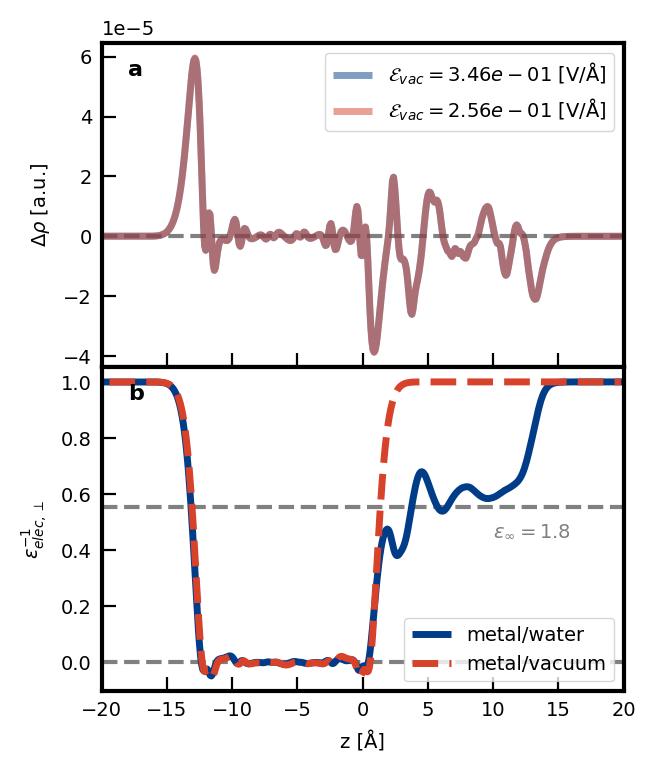

In [14]:
fig, axs = plt.subplots(nrows=2, figsize=[3, 4], sharex=True)

ax = axs[0]

dname = "../05.elec_eps/01.eps_calc/calc/001000.000/"
data = load_dict(os.path.join(dname, "eps_data_lo.pkl"))[0.0]
data_info = load_dict(os.path.join(dname, "task_info.json"))
x = data["v_grid"] - data_info["lo"]["z_ave"]
ys = data["rho_pol"]
efield_vac = data["efield_vac"]

ax.axhline(y=0.0, ls="--", color="gray", lw=1.5)

color = "blue"
ax.plot(
    x,
    ys[0],
    color=color,
    alpha=0.5,
    label=r"$\mathcal{E}_{vac}=%.2e$ [V/Å]" % efield_vac[0],
)
color = "red"
ax.plot(
    x,
    ys[1],
    color=color,
    alpha=0.5,
    label=r"$\mathcal{E}_{vac}=%.2e$ [V/Å]" % efield_vac[1],
)

ax.set_ylabel(r"$\Delta\rho$ [a.u.]")
ax.grid(False)
ax.legend()

ax = axs[1]

ax.axhline(y=0.0, ls="--", color="gray", lw=1.5)
ax.axhline(y=1 / 1.8, ls="--", color="gray", lw=1.5)

data = out_data["elec_inveps"]
color = "blue"
data = out_data["elec_inveps"]
ax.plot(data[0], data[1], color=color, label="metal/water")
color = "red"
data = out_data["elec_inveps_metal"]
ax.plot(data[0], data[1], "--", color=color, label="metal/vacuum")

plot.ax_setlabel(ax, r"z [Å]", r"$\epsilon_{elec,\perp}^{-1}$")
ax.text(10.0, 0.45, r"$\varepsilon_{\infty}=1.8$", color="gray")
ax.legend(loc="lower right")

ax.set_xlim(-20.0, 20.0)
fig.subplots_adjust(hspace=0.0)

for ax, label in zip(axs, ["a", "b"]):
    plt.text(0.05, 0.9, label, transform=ax.transAxes, fontsize=8, fontweight="bold")

fig.savefig("figs/Figure2.rho_pol_and_inveps.png", transparent=True)
plt.show()

## $\rho_e$ and $\varepsilon_{elec}$


0.0003116539923150975


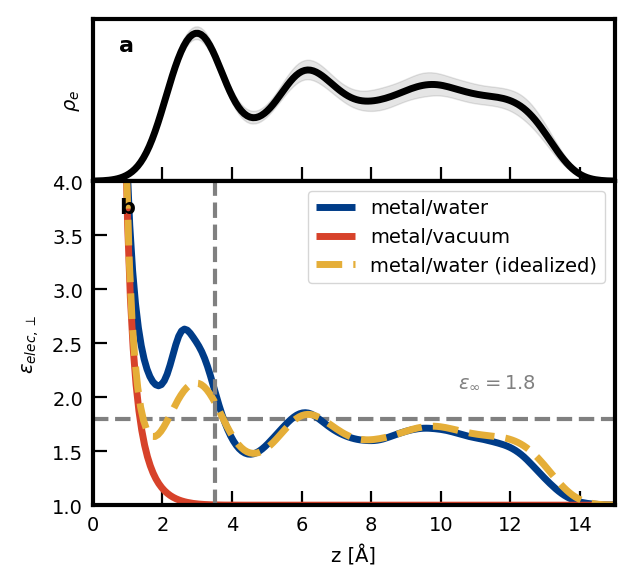

In [15]:
fig, axs = plt.subplots(nrows=2, figsize=[3, 3], sharex=True, height_ratios=[0.5, 1])

ax = axs[0]
color = "k"
data = out_data["water_polarizability"]
grid = data[0]
rho_e = data[3]
ax.plot(grid, rho_e, color=color)
ax.fill_between(grid, rho_e + data[4], rho_e - data[4], alpha=0.1, color=color)
ax.set_ylim(bottom=0.0)
ax.set_ylabel(r"$\rho_e$", color=color)
ax.set_yticks([])

ax = axs[1]
ax.axhline(y=1.8, color="gray", ls="--", lw=1.5)

color = "blue"
data = out_data["elec_inveps"]
mask = data[0] > 0.5
x = data[0][mask]
y = handle_zero_division(1.0, data[1], 1e-2)[mask]
ax.plot(x, y, color=color, label="metal/water")

mask = (grid >= 5.0) & (grid <= 10.0)
eps_interp = np.interp(grid[mask], x, y)
sfactor = (eps_interp - 1) / rho_e[mask]
print(sfactor.std())
sfactor = sfactor.mean()

color = "red"
data = out_data["elec_inveps_metal"]
mask = data[0] > 0.6
x = data[0][mask]
y = handle_zero_division(1.0, data[1], 1e-2)[mask]
ax.plot(x, y, color=color, label="metal/vacuum")

color = "C2"
eps_interp = np.interp(grid, x, y)
ax.plot(
    grid,
    rho_e * sfactor + eps_interp,
    "--",
    color=color,
    label="metal/water (idealized)",
)

ax.axvline(x=3.5, color="gray", ls="--", lw=1.5)
# ax.text(4, 2.1, r"z = 3.5Å")
ax.text(10.5, 2.1, r"$\varepsilon_{\infty}=1.8$", color="gray")

ax.set_xlim(0.0, 15.0)
ax.set_ylim(1.0, 4.0)
plot.ax_setlabel(ax, r"z [Å]", r"$\epsilon_{elec,\perp}$")

ax.legend()
fig.subplots_adjust(hspace=0.0)

fig.savefig("figs/Figure3.elec_eps_and_rho_e.png", transparent=True)

plt.text(0.05, 0.8, "a", transform=axs[0].transAxes, fontsize=8, fontweight="bold")
plt.text(0.05, 0.9, "b", transform=axs[1].transAxes, fontsize=8, fontweight="bold")

plt.show()

## eps


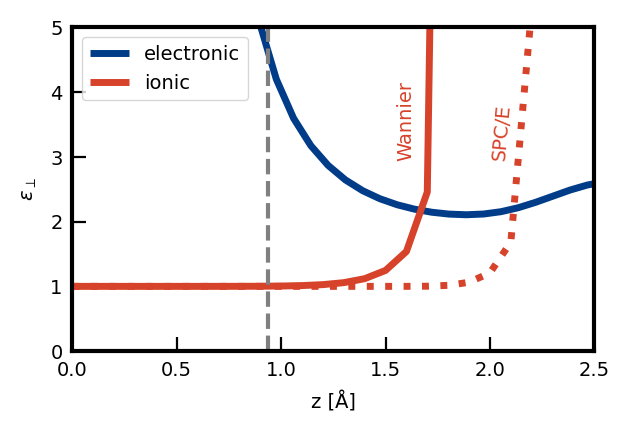

In [29]:
fig, ax = plt.subplots(figsize=[3, 2])

color = "blue"
data = out_data["elec_inveps"]
mask = data[0] > 0.5
x = data[0][mask]
y = handle_zero_division(1.0, data[1], 1e-2)[mask]
ax.plot(x, y, color="blue", label="electronic")

data = out_data["orient_inveps"]
kw = "spce_pc"
x = data[kw][0]
y = handle_zero_division(1.0, data[kw][1], 1e-2)
mask = x < 2.3
ax.plot(x[mask], y[mask], ":", color="red")
kw = "dw_gaussian"
x = data[kw][0]
y = handle_zero_division(1.0, data[kw][1], 1e-2)
mask = x < 1.9
ax.plot(x[mask], y[mask], color="red", label="ionic")

ax.set_xlim(0.0, 2.5)
ax.set_ylim(0.0, 5.0)
ax.axvline(0.935, ls="--", lw=1.5, color="gray")

ax.legend()

ax.text(1.55, 3.0, "Wannier", rotation="vertical", color="red")
ax.text(2.0, 3.0, "SPC/E", rotation=85, color="red")

plot.ax_setlabel(ax, r"z [Å]", r"$\epsilon_\perp$")

fig.savefig("figs/Figure5.eps.png")

plt.show()

# supplementary info


## validation: PES


In [15]:
def find_data(dname, fname, dim=1):
    fnames = glob.glob(os.path.join(dname, "**", fname), recursive=True)
    fnames.sort()
    # print(fnames)
    all_data = []
    for fname in fnames:
        data = np.load(fname)
        all_data.append(data.reshape(-1, dim))
    all_data = np.concatenate(all_data, axis=0)
    return all_data

rmse [meV/atom]:  0.426448403317606
rmse [meV/atom]:  0.24889235706105087
rmse [meV/A]:  58.72890905939932
rmse [meV/A]:  51.80943611706065


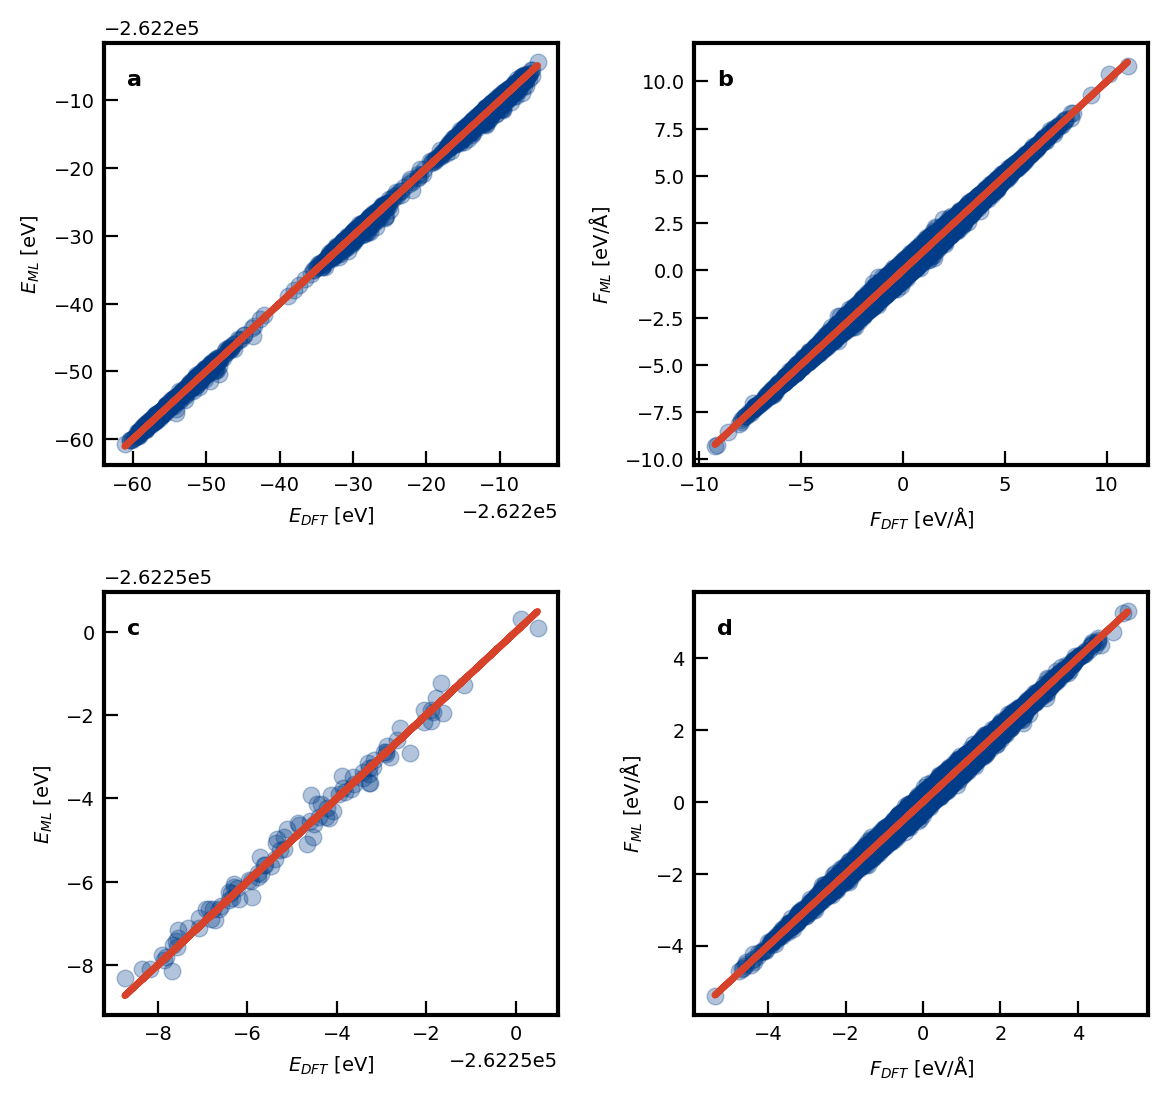

In [16]:
fig, axs = plt.subplots(2, 2, figsize=[6, 6])

fname = "energy.npy"
ax = axs[0][0]
dname = os.path.join(data_dir, "ml_validation_pes/train")
dft_data = find_data(os.path.join(dname, "dft_data"), fname)
ml_data = find_data(os.path.join(dname, "ml_data"), fname)

ax.scatter(dft_data.flatten(), ml_data.flatten(), color="blue", alpha=0.3)
ax.plot(dft_data.flatten(), dft_data.flatten(), color="red")
plot.ax_setlabel(ax, "$E_{DFT}$ [eV]", "$E_{ML}$ [eV]")

rmse = np.sqrt(mean_squared_error(dft_data.flatten(), ml_data.flatten()))
print("rmse [meV/atom]: ", rmse / 906 * 1e3)

ax = axs[1][0]
dname = os.path.join(data_dir, "ml_validation_pes/validation")
dft_data = find_data(os.path.join(dname, "dft_data"), fname)
ml_data = find_data(os.path.join(dname, "ml_data"), fname)

ax.scatter(dft_data.flatten(), ml_data.flatten(), color="blue", alpha=0.3)
ax.plot(dft_data.flatten(), dft_data.flatten(), color="red")
plot.ax_setlabel(ax, "$E_{DFT}$ [eV]", "$E_{ML}$ [eV]")

rmse = np.sqrt(mean_squared_error(dft_data.flatten(), ml_data.flatten()))
print("rmse [meV/atom]: ", rmse / 906 * 1e3)

fname = "force.npy"
ax = axs[0][1]
dname = os.path.join(data_dir, "ml_validation_pes/train")
dft_data = find_data(os.path.join(dname, "dft_data"), fname, 3)
ml_data = find_data(os.path.join(dname, "ml_data"), fname, 3)

ax.scatter(dft_data.flatten(), ml_data.flatten(), color="blue", alpha=0.3)
ax.plot(dft_data.flatten(), dft_data.flatten(), color="red")
plot.ax_setlabel(ax, "$F_{DFT}$ [eV/Å]", "$F_{ML}$ [eV/Å]")

rmse = np.sqrt(mean_squared_error(dft_data.flatten(), ml_data.flatten()))
print("rmse [meV/A]: ", rmse * 1e3)

ax = axs[1][1]
dname = os.path.join(data_dir, "ml_validation_pes/validation")
dft_data = find_data(os.path.join(dname, "dft_data"), fname, 3)
ml_data = find_data(os.path.join(dname, "ml_data"), fname, 3)

ax.scatter(dft_data.flatten(), ml_data.flatten(), color="blue", alpha=0.3)
ax.plot(dft_data.flatten(), dft_data.flatten(), color="red")
plot.ax_setlabel(ax, "$F_{DFT}$ [eV/Å]", "$F_{ML}$ [eV/Å]")

rmse = np.sqrt(mean_squared_error(dft_data.flatten(), ml_data.flatten()))
print("rmse [meV/A]: ", rmse * 1e3)

# fig.supxlabel(r"DFT data [meV/atom or meV/Å]", y=-0.05, fontsize="small")
# fig.supylabel("Probability [arb.u.]", x=-0.1, fontsize="small")
fig.subplots_adjust(hspace=0.3, wspace=0.3)

plt.text(0.05, 0.9, "a", transform=axs[0][0].transAxes, fontsize=8, fontweight="bold")
plt.text(0.05, 0.9, "b", transform=axs[0][1].transAxes, fontsize=8, fontweight="bold")
plt.text(0.05, 0.9, "c", transform=axs[1][0].transAxes, fontsize=8, fontweight="bold")
plt.text(0.05, 0.9, "d", transform=axs[1][1].transAxes, fontsize=8, fontweight="bold")

fig.savefig("figs/pes_validation.png")

plt.show()

## validation: water structure


In [17]:
prefix = "water_structure"
aimd_data = load_dict("../03.mlp_validation/data/%s.aimd_prl.pkl" % prefix)
mlmd_all_data = []
fnames = glob.glob("../03.mlp_validation/data/%s.mlmd.*.pkl" % prefix)
fnames.sort()
for fname in fnames:
    mlmd_all_data.append(load_dict(fname))

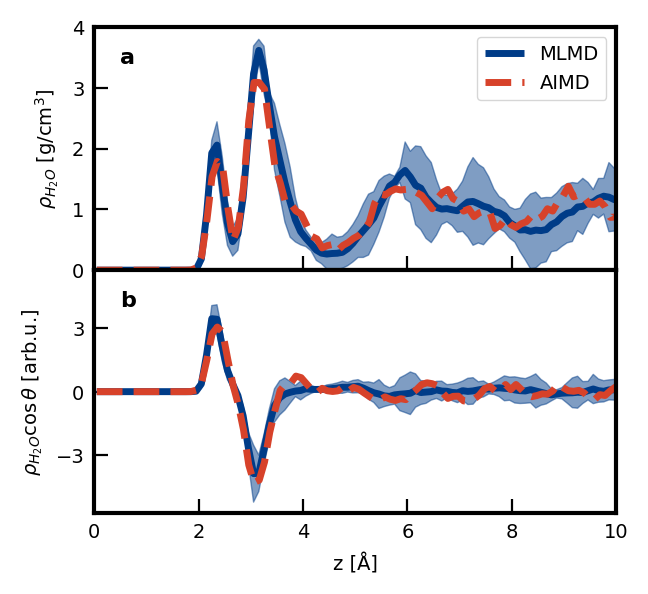

In [19]:
fig, axs = plt.subplots(2, 1, figsize=[3, 3], sharex=True)

ax = axs[0]

kw = "rho_water"

tmp_data = []
for data in mlmd_all_data:
    tmp_data.append(data[kw][1])
mlmd_data_ave = np.mean(tmp_data, axis=0)
mlmd_data_std = np.std(tmp_data, axis=0)

ax.plot(data[kw][0], mlmd_data_ave, label="MLMD", color="blue")
ax.fill_between(
    data[kw][0],
    mlmd_data_ave + 3 * mlmd_data_std,
    mlmd_data_ave - 3 * mlmd_data_std,
    color="blue",
    alpha=0.5,
)
ax.plot(aimd_data[kw][0], aimd_data[kw][1], "--", label="AIMD", color="red")

ax.legend()
plot.ax_setlabel(ax, r"z [Å]", r"$\rho_{H_2O}$ [g/cm$^3$]")

ax.set_xlim(0.0, 10.0)
ax.set_ylim(bottom=0.0)
ax.set_yticks(np.arange(5))

ax = axs[1]

kw = "geo_dipole_water"

tmp_data = []
for data in mlmd_all_data:
    tmp_data.append(data[kw][1])
mlmd_data_ave = np.mean(tmp_data, axis=0) * 1e3
mlmd_data_std = np.std(tmp_data, axis=0) * 1e3

ax.plot(data[kw][0], mlmd_data_ave, label="MLMD", color="blue")
ax.fill_between(
    data[kw][0],
    mlmd_data_ave + 3 * mlmd_data_std,
    mlmd_data_ave - 3 * mlmd_data_std,
    color="blue",
    alpha=0.5,
)
ax.plot(aimd_data[kw][0], aimd_data[kw][1] * 1e3, "--", label="AIMD", color="red")

ax.set_xlim(0.0, 10.0)
ax.set_yticks(np.arange(-3, 5, 3))

plot.ax_setlabel(ax, r"z [Å]", r"$\rho_{H_2O}\cos\theta$ [arb.u.]")

fig.subplots_adjust(hspace=0.0)
for ax, label in zip(axs, ["a", "b"]):
    plt.text(0.05, 0.85, label, transform=ax.transAxes, fontsize=8, fontweight="bold")

fig.savefig("figs/rho_water.png")

plt.show()

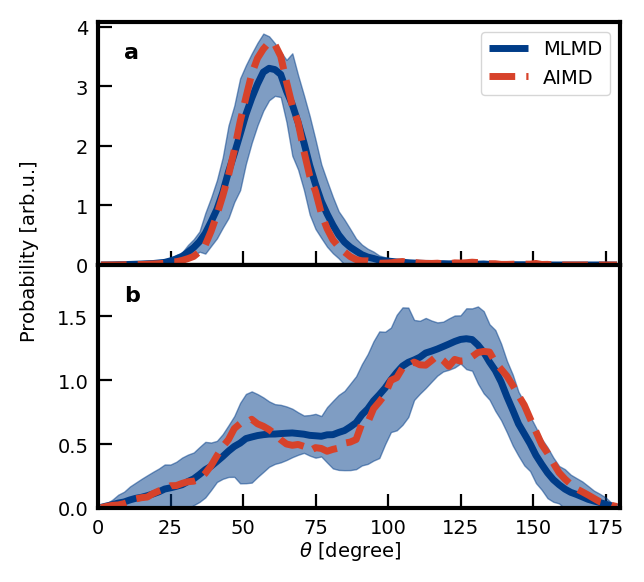

In [20]:
fig, axs = plt.subplots(2, 1, figsize=[3, 3], sharex=True)

ax = axs[0]

kw = "water_a_theta"

tmp_data = []
for data in mlmd_all_data:
    tmp_data.append(data[kw][1])
mlmd_data_ave = np.mean(tmp_data, axis=0) * 1e2
mlmd_data_std = np.std(tmp_data, axis=0) * 1e2

ax.plot(data[kw][0], mlmd_data_ave, label="MLMD", color="blue")
ax.fill_between(
    data[kw][0],
    mlmd_data_ave + 3 * mlmd_data_std,
    mlmd_data_ave - 3 * mlmd_data_std,
    color="blue",
    alpha=0.5,
)
ax.plot(aimd_data[kw][0], aimd_data[kw][1] * 1e2, "--", label="AIMD", color="red")

ax.legend()

ax.set_xlim(0.0, 180.0)
ax.set_ylim(bottom=0.0)

ax = axs[1]

kw = "water_b_theta"

tmp_data = []
for data in mlmd_all_data:
    tmp_data.append(data[kw][1])
mlmd_data_ave = np.mean(tmp_data, axis=0) * 1e2
mlmd_data_std = np.std(tmp_data, axis=0) * 1e2

ax.plot(data[kw][0], mlmd_data_ave, label="MLMD", color="blue")
ax.fill_between(
    data[kw][0],
    mlmd_data_ave + 3 * mlmd_data_std,
    mlmd_data_ave - 3 * mlmd_data_std,
    color="blue",
    alpha=0.5,
)
ax.plot(aimd_data[kw][0], aimd_data[kw][1] * 1e2, "--", label="AIMD", color="red")

ax.set_xlim(0.0, 180.0)
ax.set_ylim(0.0, 1.9)

# turn off scientific notation
ax.ticklabel_format(axis="x", style="plain")

fig.supxlabel(r"$\theta$ [degree]", y=-0.02, fontsize=7)
fig.supylabel("Probability [arb.u.]", x=-0.05, fontsize=7)

fig.subplots_adjust(hspace=0.0)
for ax, label in zip(axs, ["a", "b"]):
    plt.text(0.05, 0.85, label, transform=ax.transAxes, fontsize=8, fontweight="bold")

fig.savefig("figs/theta_water.png")

plt.show()

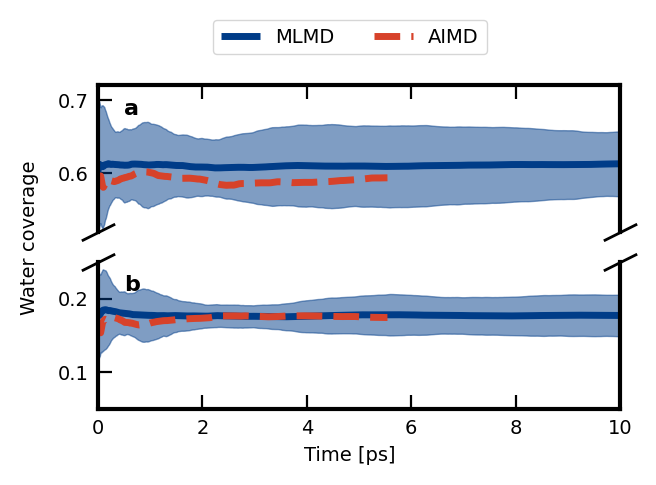

In [22]:
fig, axs = plt.subplots(2, 1, figsize=[3, 2], sharex=True)

ax = axs[0]

kw = "water_b_coverage"
tmp_data = []
for data in mlmd_all_data:
    tmp_data.append(cumave(data[kw]))
mlmd_data_ave = np.mean(tmp_data, axis=0)
mlmd_data_std = np.std(tmp_data, axis=0)

x = np.arange(len(mlmd_data_ave)) * 0.5 * 1e-3
ax.plot(x, mlmd_data_ave, label="MLMD", color="blue")
ax.fill_between(
    x,
    mlmd_data_ave + 3 * mlmd_data_std,
    mlmd_data_ave - 3 * mlmd_data_std,
    color="blue",
    alpha=0.5,
)

x = np.arange(len(aimd_data[kw])) * 0.5 * 1e-3
ax.plot(x, cumave(aimd_data[kw]), "--", label="AIMD", color="red")

ax.set_ylim(0.52, 0.72)

ax.ticklabel_format(axis="y", style="plain")

ax.spines.bottom.set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)

ax = axs[1]

kw = "water_a_coverage"
tmp_data = []
for data in mlmd_all_data:
    tmp_data.append(cumave(data[kw]))
mlmd_data_ave = np.mean(tmp_data, axis=0)
mlmd_data_std = np.std(tmp_data, axis=0)

x = np.arange(len(mlmd_data_ave)) * 0.5 * 1e-3
ax.plot(x, mlmd_data_ave, color="blue")
ax.fill_between(
    x,
    mlmd_data_ave + 3 * mlmd_data_std,
    mlmd_data_ave - 3 * mlmd_data_std,
    color="blue",
    alpha=0.5,
)

x = np.arange(len(aimd_data[kw])) * 0.5 * 1e-3
ax.plot(x, cumave(aimd_data[kw]), "--", color="red")

ax.set_xlim(0.0, 10.0)
ax.set_ylim(0.05, 0.25)

ax.ticklabel_format(axis="y", style="plain")

ax.spines.top.set_visible(False)
ax.xaxis.tick_bottom()

# ax.set_yticks(np.arange(0., 10, 2.5))
# ax.set_ylim(0, 9)

# fig.supxlabel(r"N$_\text{atom}$", y=-0.08)
# fig.supylabel(r"t / t$_\text{tot}$ [%]", x=-0.08)

# ax.legend(loc="right")

d = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(
    marker=[(-1, -d), (1, d)],
    markersize=12,
    linestyle="none",
    color="k",
    mec="k",
    mew=1,
    clip_on=False,
)
axs[0].plot([0, 1], [0, 0], transform=axs[0].transAxes, **kwargs)
axs[1].plot([0, 1], [1, 1], transform=axs[1].transAxes, **kwargs)

lines = []
labels = []
for ax in fig.axes:
    Line, Label = ax.get_legend_handles_labels()
    lines.extend(Line)
    labels.extend(Label)
fig.legend(lines, labels, ncols=3, loc="center", bbox_to_anchor=[0.5, 1.0])

fig.supxlabel("Time [ps]", y=-0.07, fontsize=7)
fig.supylabel("Water coverage", x=-0.05, fontsize=7)

for ax, label in zip(axs, ["a", "b"]):
    plt.text(0.05, 0.8, label, transform=ax.transAxes, fontsize=8, fontweight="bold")

fig.savefig("figs/water_coverage.png")

plt.show()

## validation: hydrogen bond


In [36]:
prefix = "water_structure"
data = load_dict("../03.mlp_validation/data/%s.aimd_prl.pkl" % prefix)
n_water_a_aimd = (data["water_a_coverage"] * 36 * 2).mean()
n_water_b_aimd = (data["water_b_coverage"] * 36 * 2).mean()

n_water_a_mlmd = []
n_water_b_mlmd = []
fnames = glob.glob("../03.mlp_validation/data/%s.mlmd.*.pkl" % prefix)
fnames.sort()
for fname in fnames:
    data = load_dict(fname)
    n_water_a_mlmd.append((data["water_a_coverage"] * 36 * 2).mean())
    n_water_b_mlmd.append((data["water_b_coverage"] * 36 * 2).mean())
n_water_a_mlmd = np.mean(n_water_a_mlmd)
n_water_b_mlmd = np.mean(n_water_b_mlmd)

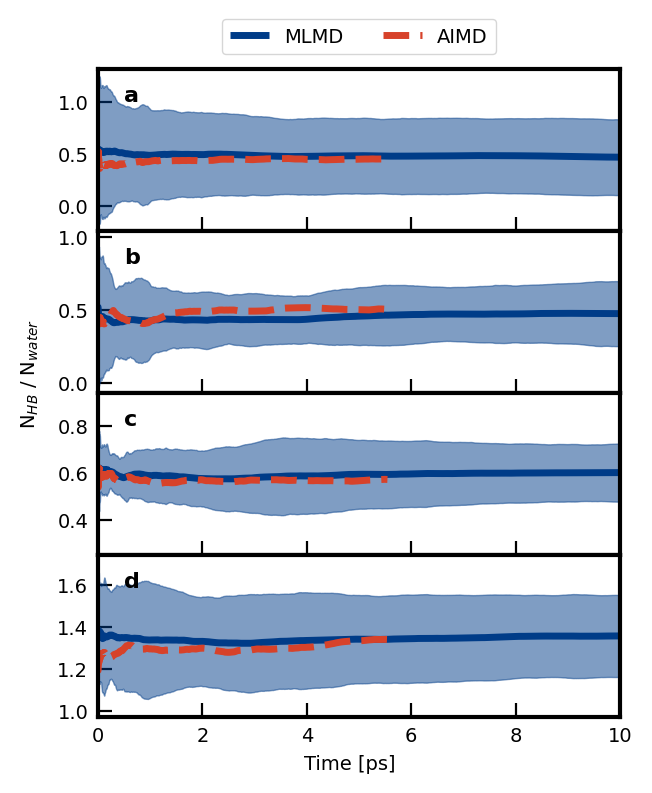

In [39]:
fig, axs = plt.subplots(4, 1, figsize=[3, 4], sharex=True)

ax = axs[0]
kw = "wata_d"

fnames = glob.glob("../03.mlp_validation/data/hb.mlmd.*.%s_count_by_time.npy" % kw)
fnames.sort()
tmp_data = []
for fname in fnames:
    mlmd_data = np.load(fname)
    tmp_data.append(mlmd_data[2])
mlmd_data_ave = np.mean(tmp_data, axis=0) / n_water_a_mlmd
mlmd_data_std = np.std(tmp_data, axis=0) / n_water_a_mlmd
ax.plot(mlmd_data[0] - mlmd_data[0][0], mlmd_data_ave, color="blue", label="MLMD")
ax.fill_between(
    mlmd_data[0] - mlmd_data[0][0],
    mlmd_data_ave + 3 * mlmd_data_std,
    mlmd_data_ave - 3 * mlmd_data_std,
    color="blue",
    alpha=0.5,
)

aimd_data = np.load("../03.mlp_validation/data/hb.aimd_prl.%s_count_by_time.npy" % kw)
ax.plot(
    aimd_data[0] - aimd_data[0][0],
    aimd_data[2] / n_water_a_aimd,
    "--",
    color="red",
    label="AIMD",
)

ax.ticklabel_format(axis="y", style="plain")
ax.legend(ncols=2, loc="center", bbox_to_anchor=[0.5, 1.2])

ax = axs[1]
kw = "wata_a"

fnames = glob.glob("../03.mlp_validation/data/hb.mlmd.*.%s_count_by_time.npy" % kw)
fnames.sort()
tmp_data = []
for fname in fnames:
    mlmd_data = np.load(fname)
    tmp_data.append(mlmd_data[2])
mlmd_data_ave = np.mean(tmp_data, axis=0) / n_water_a_mlmd
mlmd_data_std = np.std(tmp_data, axis=0) / n_water_a_mlmd
ax.plot(mlmd_data[0] - mlmd_data[0][0], mlmd_data_ave, color="blue")
ax.fill_between(
    mlmd_data[0] - mlmd_data[0][0],
    mlmd_data_ave + 3 * mlmd_data_std,
    mlmd_data_ave - 3 * mlmd_data_std,
    color="blue",
    alpha=0.5,
)

aimd_data = np.load("../03.mlp_validation/data/hb.aimd_prl.%s_count_by_time.npy" % kw)
ax.plot(
    aimd_data[0] - aimd_data[0][0], aimd_data[2] / n_water_a_aimd, "--", color="red"
)

ax.ticklabel_format(axis="y", style="plain")

ax = axs[2]
kw = "watb_d"

fnames = glob.glob("../03.mlp_validation/data/hb.mlmd.*.%s_count_by_time.npy" % kw)
fnames.sort()
tmp_data = []
for fname in fnames:
    mlmd_data = np.load(fname)
    tmp_data.append(mlmd_data[2])
mlmd_data_ave = np.mean(tmp_data, axis=0) / n_water_b_mlmd
mlmd_data_std = np.std(tmp_data, axis=0) / n_water_b_mlmd
ax.plot(mlmd_data[0] - mlmd_data[0][0], mlmd_data_ave, color="blue")
ax.fill_between(
    mlmd_data[0] - mlmd_data[0][0],
    mlmd_data_ave + 3 * mlmd_data_std,
    mlmd_data_ave - 3 * mlmd_data_std,
    color="blue",
    alpha=0.5,
)

aimd_data = np.load("../03.mlp_validation/data/hb.aimd_prl.%s_count_by_time.npy" % kw)
ax.plot(
    aimd_data[0] - aimd_data[0][0], aimd_data[2] / n_water_b_aimd, "--", color="red"
)

ax.ticklabel_format(axis="y", style="plain")

ax = axs[3]
kw = "watb_a"

fnames = glob.glob("../03.mlp_validation/data/hb.mlmd.*.%s_count_by_time.npy" % kw)
fnames.sort()
tmp_data = []
for fname in fnames:
    mlmd_data = np.load(fname)
    tmp_data.append(mlmd_data[2])
mlmd_data_ave = np.mean(tmp_data, axis=0) / n_water_b_mlmd
mlmd_data_std = np.std(tmp_data, axis=0) / n_water_b_mlmd
ax.plot(mlmd_data[0] - mlmd_data[0][0], mlmd_data_ave, color="blue")
ax.fill_between(
    mlmd_data[0] - mlmd_data[0][0],
    mlmd_data_ave + 3 * mlmd_data_std,
    mlmd_data_ave - 3 * mlmd_data_std,
    color="blue",
    alpha=0.5,
)

aimd_data = np.load("../03.mlp_validation/data/hb.aimd_prl.%s_count_by_time.npy" % kw)
ax.plot(
    aimd_data[0] - aimd_data[0][0], aimd_data[2] / n_water_b_aimd, "--", color="red"
)

ax.ticklabel_format(axis="y", style="plain")

ax.set_xlim(0.0, 10.0)

fig.supxlabel("Time [ps]", y=-0.0, fontsize=7)
fig.supylabel(r"N$_{HB}$ / N$_{water}$", x=-0.05, fontsize=7)

fig.subplots_adjust(hspace=0.0)

for ax, label in zip(axs, ["a", "b", "c", "d"]):
    plt.text(0.05, 0.8, label, transform=ax.transAxes, fontsize=8, fontweight="bold")

fig.savefig("figs/water_hb.png")

plt.show()

## validation: survival probability


In [24]:
prefix = "water_sp"
aimd_data = load_dict("../03.mlp_validation/data/%s.aimd_prl.pkl" % prefix)
mlmd_all_data = []
fnames = glob.glob("../03.mlp_validation/data/%s.mlmd.*.pkl" % prefix)
fnames.sort()
for fname in fnames:
    mlmd_all_data.append(load_dict(fname))

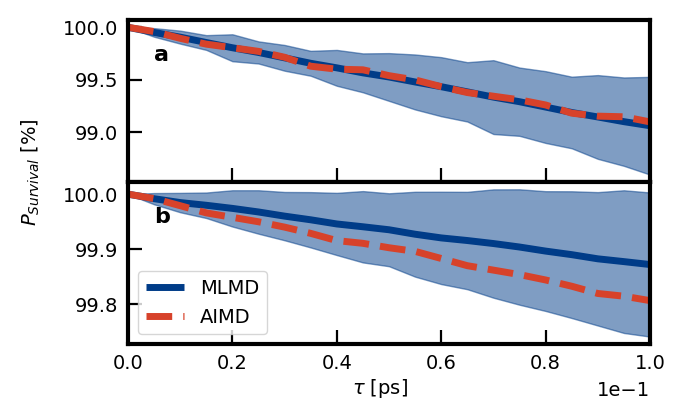

In [27]:
fig, axs = plt.subplots(2, 1, figsize=[3, 2], sharex=True)

# timestep [ps]
ts = 0.5 * 10 * 1e-3

ax = axs[0]
kw = "water_a"

tmp_data = []
for data in mlmd_all_data:
    tmp_data.append(data[kw][1])
mlmd_data_ave = np.mean(tmp_data, axis=0) * 1e2
mlmd_data_std = np.std(tmp_data, axis=0) * 1e2

x = ts * data[kw][0]
ax.plot(x, mlmd_data_ave, label="MLMD", color="blue")
ax.fill_between(
    x,
    mlmd_data_ave + 3 * mlmd_data_std,
    mlmd_data_ave - 3 * mlmd_data_std,
    color="blue",
    alpha=0.5,
)

ax.plot(ts * aimd_data[kw][0], aimd_data[kw][1] * 1e2, "--", label="AIMD", color="red")

ax.ticklabel_format(axis="y", style="plain")

ax = axs[1]
kw = "water_a_and_b"

tmp_data = []
for data in mlmd_all_data:
    tmp_data.append(data[kw][1])
mlmd_data_ave = np.mean(tmp_data, axis=0) * 1e2
mlmd_data_std = np.std(tmp_data, axis=0) * 1e2

x = ts * data[kw][0]
ax.plot(x, mlmd_data_ave, label="MLMD", color="blue")
ax.fill_between(
    x,
    mlmd_data_ave + 3 * mlmd_data_std,
    mlmd_data_ave - 3 * mlmd_data_std,
    color="blue",
    alpha=0.5,
)

ax.plot(ts * aimd_data[kw][0], aimd_data[kw][1] * 1e2, "--", label="AIMD", color="red")
ax.legend(loc="lower left")

ax.set_xlim(0.0, 0.1)
ax.ticklabel_format(axis="y", style="plain")

fig.supxlabel(r"$\tau$ [ps]", y=-0.07, fontsize=7)
fig.supylabel(r"$P_{Survival}$ [%]", x=-0.1, fontsize=7)

fig.subplots_adjust(hspace=0.0)
for ax, label in zip(axs, ["a", "b"]):
    plt.text(0.05, 0.75, label, transform=ax.transAxes, fontsize=8, fontweight="bold")

fig.savefig("figs/water_sp.png")

plt.show()

## ET example


In [19]:
dname = "../05.elec_eps/01.eps_calc/calc/002300.000/"
data = load_dict(os.path.join(dname, "eps_data_lo.pkl"))[0.0]
data_info = load_dict(os.path.join(dname, "task_info.json"))

atoms = io.read(os.path.join(dname, "ref_lo/coord.xyz"))
z_l = atoms[atoms.symbols == "Pt"][:36].get_positions()[:, 2].mean()
z_r = atoms[atoms.symbols == "Pt"][-36:].get_positions()[:, 2].mean()

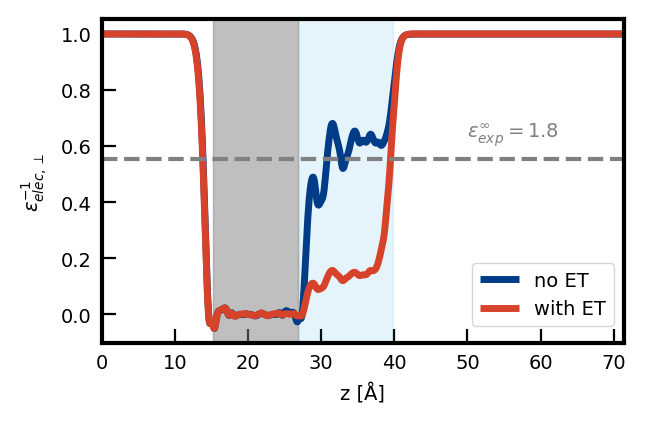

In [20]:
fig, ax = plt.subplots(figsize=[3, 2])

# x = data["v_prime_grid"] - data_info["lo"]["z_ave"]
x = data["v_prime_grid"]

color = "blue"
ax.plot(x, data["inveps"][-1], color=color, label=r"no ET")

color = "red"
ax.plot(x, data["inveps"][0], color=color, label="with ET")

ylim = ax.get_ylim()
mask = (x <= z_r) & (x >= z_l)
ax.fill_between(
    x,
    ylim[0],
    ylim[1],
    where=mask,
    color="gray",
    alpha=0.5,
)
mask = (x >= z_r) & (x <= (z_r + 13.0))
ax.fill_between(
    x,
    ylim[0],
    ylim[1],
    where=mask,
    color="C0",
    alpha=0.1,
)

ax.set_xlim(0.0, x.max())
ax.set_ylim(ylim)

ax.axhline(y=1 / 1.8, color="gray", ls="--", lw=1.5)
ax.text(50, 0.63, r"$\varepsilon_{exp}^{\infty}=1.8$", color="gray")

plot.ax_setlabel(ax, r"z [Å]", r"$\epsilon_{elec,\perp}^{-1}$")
ax.legend(loc="right", bbox_to_anchor=(1.0, 0.15))

fig.savefig("figs/level_mismatch_example.png", transparent=True)
plt.show()

## level misalignment


In [21]:
def grep_data(dname):
    fnames = glob.glob(os.path.join(dname, "cp2k-list*-1.pdos"))
    fnames.sort()
    vbm = []
    cbm = []
    for ii in range(len(fnames)):
        pdos = Cp2kPdos(os.path.join(dname, "cp2k-list%d-1.pdos" % (ii + 1)))
        vbm.append(pdos.vbm)
        cbm.append(pdos.cbm)

    atoms = io.read(os.path.join(dname, "coord.xyz"))
    z = atoms.get_positions()[:, 2][atoms.symbols == "O"]

    sort_ids = np.argsort(z)
    return z[sort_ids], np.array(vbm)[sort_ids], np.array(cbm)[sort_ids]

In [22]:
out_pbc = grep_data("../05.elec_eps/04.level_misalignment/pbc")
out_dip_cor = grep_data("../05.elec_eps/04.level_misalignment/dip_cor")

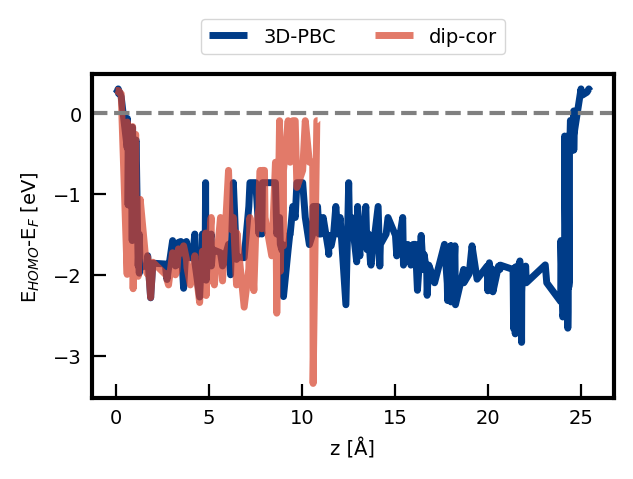

In [23]:
fig, ax = plt.subplots(figsize=[3, 2])
ax.plot(out_pbc[0] - out_pbc[0][0], out_pbc[1], color="blue", label="3D-PBC")
# ax.plot(out_pbc[0], out_pbc[2], color="blue")

ax.plot(
    out_dip_cor[0] - out_dip_cor[0][0],
    out_dip_cor[1],
    color="red",
    alpha=0.7,
    label="dip-cor",
)
# ax.plot(out_dip_cor[0], out_dip_cor[2], ":", color="blue")

plot.ax_setlabel(ax, "z [Å]", r"E$_{HOMO}$-E$_F$ [eV]")
ax.axhline(y=0.0, ls="--", color="gray", lw=1.5)
ax.legend(ncols=2, loc="upper center", bbox_to_anchor=(0.5, 1.2))

fig.savefig("figs/water_homo_vs_fermi.png")

plt.show()

## water thickness test


In [24]:
fnames_ref = glob.glob("../05.elec_eps/00.l_water_test/13A/calc/*/eps_data_*.pkl")
fnames_test = glob.glob("../05.elec_eps/00.l_water_test/10A/calc/*/eps_data_*.pkl")
fnames_ref.sort()
fnames_test.sort()

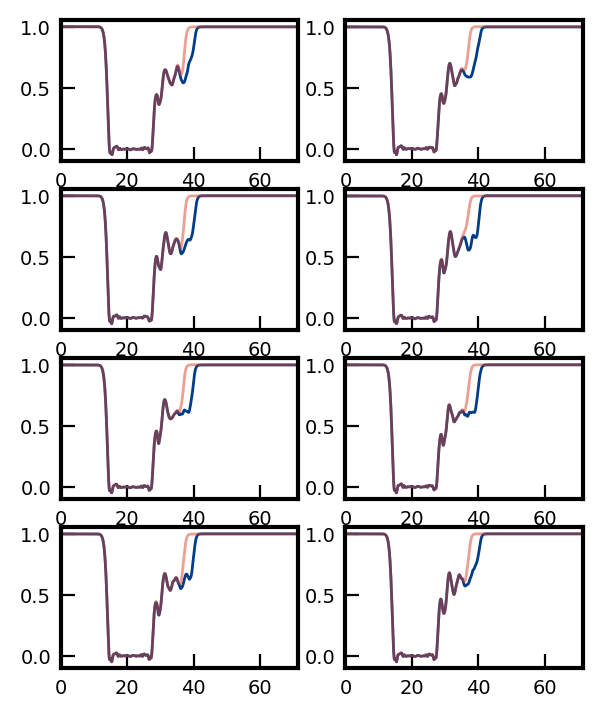

In [25]:
nrows = len(fnames_ref) // 2
fig, axs = plt.subplots(nrows, 2, figsize=[3, nrows])

lw = 1
for ii, fname_ref, fname_test in zip(
    np.arange(nrows), fnames_ref[::2], fnames_test[::2]
):
    data_ref = load_dict(fname_ref)[0.0]
    data_test = load_dict(fname_test)[0.0]
    ax = axs[ii][0]

    ax.plot(
        data_ref["v_prime_grid"],
        data_ref["inveps"][-1],
        color="blue",
        lw=lw,
        label="13Å",
    )
    ax.plot(
        data_test["v_prime_grid"],
        data_test["inveps"][-1],
        color="red",
        lw=lw,
        label="10Å",
        alpha=0.5,
    )

    ax.set_xlim(0.0, 71.478)

for ii, fname_ref, fname_test in zip(
    np.arange(nrows), fnames_ref[1::2], fnames_test[1::2]
):
    data_ref = load_dict(fname_ref)[0.0]
    data_test = load_dict(fname_test)[0.0]
    ax = axs[ii][1]

    ax.plot(
        data_ref["v_prime_grid"],
        data_ref["inveps"][-1],
        color="blue",
        lw=lw,
        label="13Å",
    )
    ax.plot(
        data_test["v_prime_grid"],
        data_test["inveps"][-1],
        color="red",
        lw=lw,
        label="10Å",
        alpha=0.5,
    )

    ax.set_xlim(0.0, 71.478)

plt.show()

In [26]:
data_ref = load_dict(
    "../05.elec_eps/00.l_water_test/13A/calc/000000.000/eps_data_lo.pkl"
)[0.0]
data_test = load_dict(
    "../05.elec_eps/00.l_water_test/10A/calc/000000.000/eps_data_lo.pkl"
)[0.0]
atoms = io.read("../05.elec_eps/00.l_water_test/10A/calc/000000.000/ref_lo/coord.xyz")
z_l = atoms[atoms.symbols == "Pt"][:36].get_positions()[:, 2].mean()
z_r = atoms[atoms.symbols == "Pt"][-36:].get_positions()[:, 2].mean()

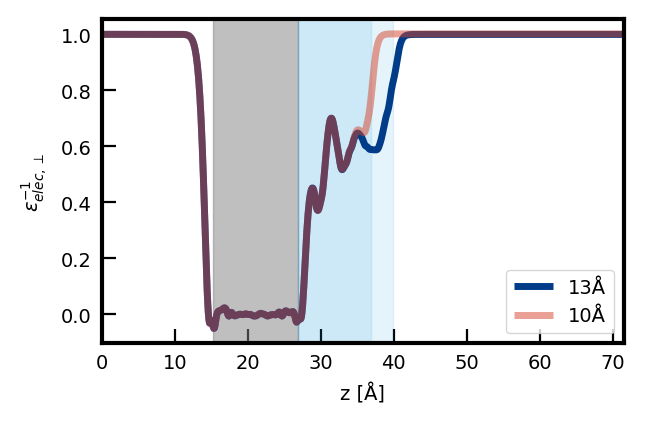

In [27]:
fig, ax = plt.subplots(figsize=[3, 2])

ax.plot(data_ref["v_prime_grid"], data_ref["inveps"][-1], color="blue", label="13Å")
ax.plot(
    data_test["v_prime_grid"],
    data_test["inveps"][-1],
    color="red",
    alpha=0.5,
    label="10Å",
)

ylim = ax.get_ylim()
x = data_test["v_prime_grid"]
mask = (x <= z_r) & (x >= z_l)
ax.fill_between(
    x,
    ylim[0],
    ylim[1],
    where=mask,
    color="gray",
    alpha=0.5,
)
mask = (x <= (z_r + 10.0)) & (x >= z_r)
ax.fill_between(
    x,
    ylim[0],
    ylim[1],
    where=mask,
    color="C0",
    alpha=0.1,
)
mask = (x <= (z_r + 13.0)) & (x >= z_r)
ax.fill_between(
    x,
    ylim[0],
    ylim[1],
    where=mask,
    color="C0",
    alpha=0.1,
)

ax.set_xlim(0.0, 71.478)
ax.set_ylim(ylim)

plot.ax_setlabel(ax, "z [Å]", r"$\epsilon_{elec,\perp}^{-1}$")
ax.legend()
fig.savefig("figs/l_water_test.png", transparent=True)

plt.show()

## linear response


In [31]:
dname = "../05.elec_eps/01.eps_calc/calc"
fnames = glob.glob(os.path.join(dname, "*/eps_data_*.pkl"))
fnames.sort()

inveps_1 = []
inveps_2 = []
for fname in fnames:
    data = load_dict(fname)[0.0]
    inveps_1.append(data["inveps"][-1])
    inveps_2.append(data["inveps"][-2])
print(len(inveps_1))
# block ave
n_block = 3
l_block = int(len(inveps_1) // 3)
inveps = []
for ii in range(n_block):
    inveps.append(np.mean(inveps_1[ii * l_block : (ii + 1) * l_block], axis=0))
inveps_1 = np.mean(inveps_1, axis=0)
inveps_2 = np.mean(inveps_2, axis=0)

66


In [29]:
dname = "../05.elec_eps/01.eps_calc/calc"
fnames = glob.glob(os.path.join(dname, "*/ref_*/coord.xyz"))
fnames.sort()

z_surf = []
for fname in fnames:
    atoms = io.read(fname)
    z_1 = atoms[atoms.symbols == "Pt"][:36].get_positions()[:, 2].mean()
    z_2 = atoms[atoms.symbols == "Pt"][-36:].get_positions()[:, 2].mean()
    z_surf.extend([z_1, z_2])
z_surf = np.sort(z_surf).reshape(2, -1).mean(axis=-1)

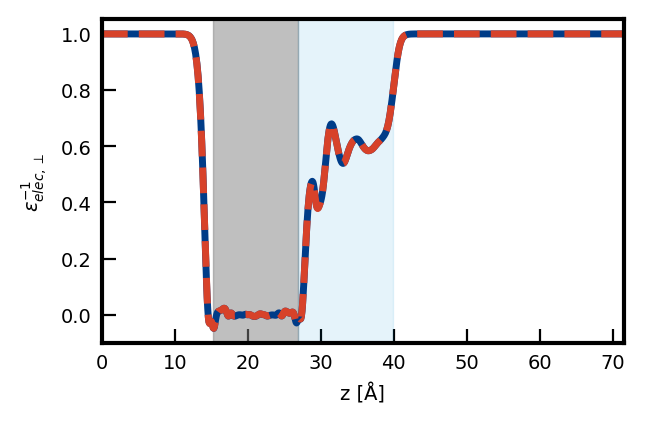

In [32]:
fig, ax = plt.subplots(figsize=[3, 2])

x = data["v_prime_grid"]
ax.plot(x, inveps_1, color="blue")
ax.plot(x, inveps_2, "--", color="red")
# ax.fill_between(
#     x,
#     inveps_1 + np.std(inveps, axis=0),
#     inveps_1 - np.std(inveps, axis=0),
# )
ylim = ax.get_ylim()
mask = (x >= z_surf[0]) & (x <= z_surf[1])
ax.fill_between(
    x,
    ylim[0],
    ylim[1],
    where=mask,
    color="gray",
    alpha=0.5,
)
mask = (x >= z_surf[1]) & (x <= (z_surf[1] + 13.0))
ax.fill_between(
    x,
    ylim[0],
    ylim[1],
    where=mask,
    color="C0",
    alpha=0.1,
)

ax.set_xlim(0.0, x.max())
ax.set_ylim(ylim)

ax.set_xlim(0.0, 71.478)
plot.ax_setlabel(ax, "z [Å]", r"$\epsilon_{elec,\perp}^{-1}$")

fig.savefig("figs/linear_response_test.png", transparent=True)

plt.show()

## inveps_elec uncertainty


In [11]:
np.std(inveps, axis=0).max()

0.009943755200087853

## image plane


In [27]:
fnames = glob.glob("../05.elec_eps/01.eps_calc/calc/*/ref_*/coord.xyz")
fnames.sort()
l_slab = []
for fname in fnames:
    atoms = io.read(fname)
    mask = atoms.symbols == "Pt"
    z = np.sort(atoms[mask].get_positions()[:, 2])
    l_slab.append(z[-36:].mean() - z[:36].mean())

dnames = glob.glob("../05.elec_eps/01.eps_calc/calc/*.000/")
dnames.sort()

x = []
y = []
for dname in dnames:
    for suffix in ["lo", "hi"]:
        data = load_dict(os.path.join(dname, "eps_data_%s.pkl" % suffix))[0.0]
        data_info = load_dict(os.path.join(dname, "task_info.json"))
        x.append(data["v_grid"] - data_info[suffix]["z_ave"])
        y.append(data["rho_pol"][-1])
x_ave = np.mean(x, axis=0)
y_ave = np.mean(y, axis=0)

In [28]:
print("img plane (metal-water): ", x_ave[np.argmin(y_ave)])
print("img plane (metal-vac): ", np.mean(l_slab) + x_ave[np.argmax(y_ave)])

img plane (metal-water):  0.9355389937178002
img plane (metal-vac):  -1.1496143666824867


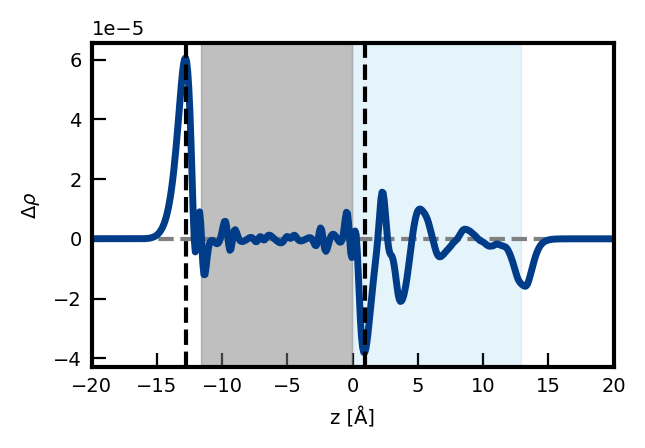

In [31]:
fig, ax = plt.subplots(figsize=[3, 2])

ax.axhline(y=0.0, ls="--", color="gray", lw=1.5)


color = "blue"
ax.plot(x_ave, y_ave, color=color)

ylim = ax.get_ylim()
mask = (x_ave <= 0.0) & (x_ave >= -np.mean(l_slab))
ax.fill_between(
    x_ave,
    ylim[0],
    ylim[1],
    where=mask,
    color="gray",
    alpha=0.5,
)
mask = (x_ave >= 0.0) & (x_ave <= 13.0)
ax.fill_between(
    x_ave,
    ylim[0],
    ylim[1],
    where=mask,
    color="C0",
    alpha=0.1,
)

ax.set_xlim(-20.0, 20.0)
ax.set_ylim(ylim)
plot.ax_setlabel(ax, "z [Å]", r"$\Delta\rho$")

ax.axvline(x=x_ave[np.argmin(y_ave)], ls="--", lw=1.5)
ax.axvline(x=x_ave[np.argmax(y_ave)], ls="--", lw=1.5)

fig.savefig("figs/img_plane.png")

plt.show()

## DFT spread fitting


In [18]:
mu_oxygen = 5.29815450
mu_hydrogen = 4.70184550


def gaussian_func(x, mu, sigma):
    """
    Gaussian function
    """
    return stats.norm.pdf(x, loc=mu, scale=sigma)


# func to fit two Gaussian peaks
def obj_func(x, a_1, sigma_1, a_2, sigma_2):
    """
    Objective function to fit two Gaussian peaks
    """
    return a_1 * gaussian_func(x, mu_oxygen, sigma_1) + a_2 * gaussian_func(
        x, mu_hydrogen, sigma_2
    )


def fit_two_gaussian_peaks(x, y, a_1, sigma_1, a_2, sigma_2):
    """
    Fit two Gaussian peaks
    """
    popt, _ = optimize.curve_fit(obj_func, x, y, p0=[a_1, sigma_1, a_2, sigma_2])
    return popt

In [19]:
rho_e_data = np.load("../06.orient_eps/01.cp2k_spread_fitting/rho_e.npy")
rho_n_data = np.load("../06.orient_eps/01.cp2k_spread_fitting/rho_n.npy")

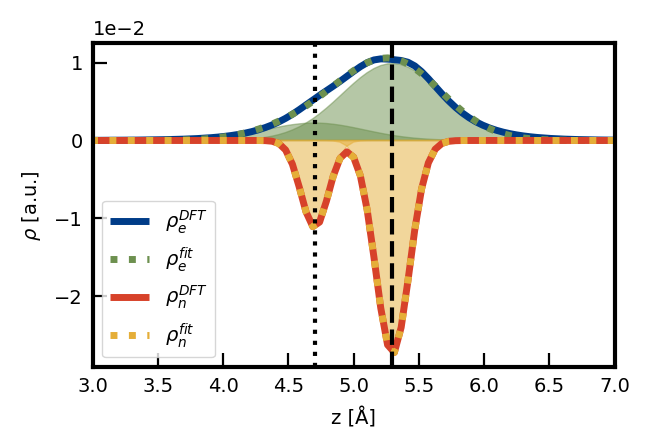

In [28]:
fig, ax = plt.subplots(figsize=[3, 2])

rho_e_data = np.load("../06.orient_eps/01.cp2k_spread_fitting/rho_e.npy")
rho_n_data = np.load("../06.orient_eps/01.cp2k_spread_fitting/rho_n.npy")

x = rho_e_data[0]
y = rho_e_data[1]
ax.plot(x, y, color="blue", label=r"$\rho_e^{DFT}$")
popt_e = fit_two_gaussian_peaks(x, y, 1e-2, 1, 1e-2, 1)
color = "C3"
ax.plot(x, obj_func(x, *popt_e), ":", color=color, label=r"$\rho_e^{fit}$")
ax.fill_between(
    x,
    0,
    popt_e[0] * gaussian_func(x, mu_oxygen, popt_e[1]),
    color=color,
    alpha=0.5,
)
ax.fill_between(
    x,
    0,
    popt_e[2] * gaussian_func(x, mu_hydrogen, popt_e[3]),
    color=color,
    alpha=0.5,
)

x = rho_n_data[0]
y = rho_n_data[1]
ax.plot(x, y, color="red", label=r"$\rho_n^{DFT}$")
popt_n = fit_two_gaussian_peaks(x, y, -2e-2, 1, -1e-2, 1)
color = "C2"
ax.plot(x, obj_func(x, *popt_n), ":", color=color, label=r"$\rho_n^{fit}$")
ax.fill_between(
    x,
    0,
    popt_n[0] * gaussian_func(x, mu_oxygen, popt_n[1]),
    color=color,
    alpha=0.5,
)
ax.fill_between(
    x,
    0,
    popt_n[2] * gaussian_func(x, mu_hydrogen, popt_n[3]),
    color=color,
    alpha=0.5,
)

ax.set_xlim(3.0, 7.0)
plot.ax_setlabel(ax, "z [Å]", r"$\rho$ [a.u.]")

ax.axvline(x=mu_oxygen, ls="--", color="k", lw=1.5)
ax.axvline(x=mu_hydrogen, ls=":", color="k", lw=1.5)

ax.legend()

fig.savefig("figs/cp2k_spread.png")
plt.show()